# Setting Up PySpark

In [1]:
# Installing Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
# Setting environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [3]:
# Initializing Spark
import findspark
findspark.init()

# Initialize Spark Session

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [5]:
# Creating Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("AirbnbAnalysis") \
    .getOrCreate()

# Data Loading and Initial Exploration


In [6]:
# Loading the dataset with correct schema
df = spark.read.csv('/content/AB_NYC_2019.csv', header=True, inferSchema=True)

# Define correct schema for relevant columns
schema = df.schema
for field in schema:
    if field.name in ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']:
        field.dataType = DoubleType()

# Load data with the defined schema, coercing errors
df = spark.read.csv('/content/AB_NYC_2019.csv', header=True, schema=schema, mode="DROPMALFORMED")

In [7]:
# Show schema
print("Schema:")
df.printSchema()

Schema:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- minimum_nights: double (nullable = true)
 |-- number_of_reviews: double (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: double (nullable = true)



In [8]:
print("\nSample data:")
df.show(5)


Sample data:
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|149.0|           1.0|              9.0| 2018-10-19|             0.21|                           6.0|           365.0|
|2595|Skylit Midtown Ca...|   2845|   Jennifer|   

# Data Cleaning and Preprocessing

In [9]:
# Checking for null values
print("Null values count:")
from pyspark.sql.functions import col
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"{col_name}: {null_count}")

Null values count:
name: 32
host_id: 185
host_name: 206
neighbourhood_group: 185
neighbourhood: 185
latitude: 185
longitude: 185
room_type: 185
price: 185
minimum_nights: 185
number_of_reviews: 205
last_review: 10234
reviews_per_month: 10215
calculated_host_listings_count: 187
availability_365: 342


In [10]:
# Droping rows with null values after attempting type conversion
df = df.na.drop()

In [11]:
print("\nAfter cleaning:")
df.show(5)


After cleaning:
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|149.0|           1.0|              9.0| 2018-10-19|             0.21|                           6.0|           365.0|
|2595|Skylit Midtown Ca...|   2845|   Jennifer|

#Exploratory Data Analysis (EDA)

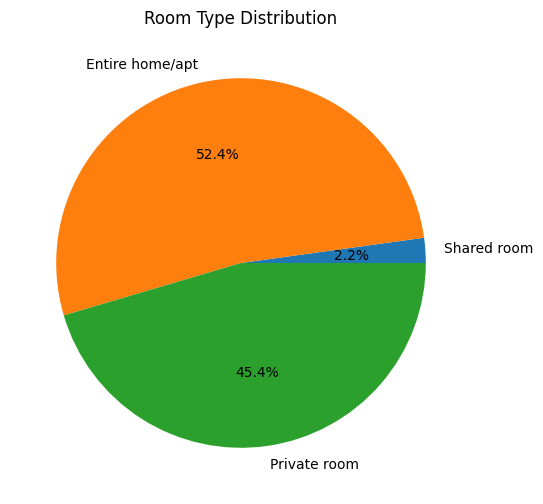

In [12]:
room_type_counts = df.groupBy("room_type").count().toPandas()

plt.figure(figsize=(8, 6))
plt.pie(room_type_counts['count'], labels=room_type_counts['room_type'], autopct='%1.1f%%')
plt.title('Room Type Distribution')
plt.show()

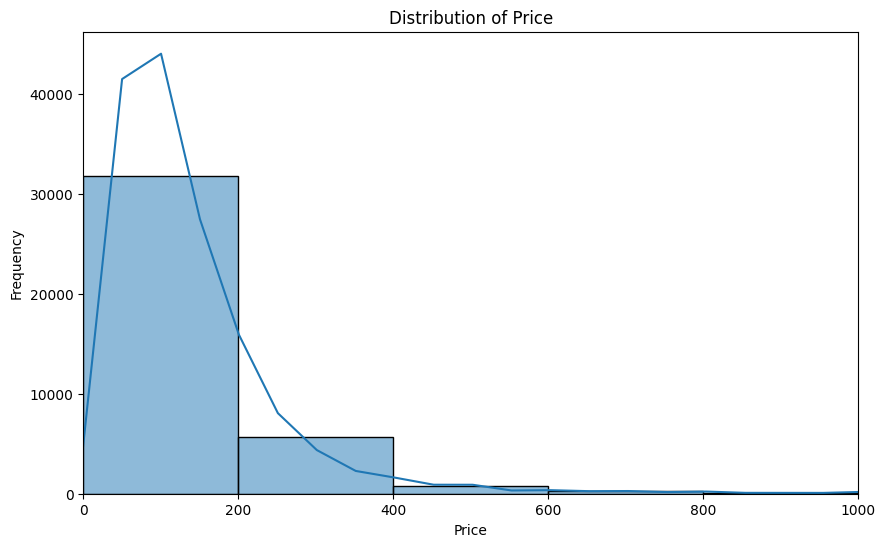

In [13]:
# Distribution of price
price_distribution = df.select("price").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(price_distribution['price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

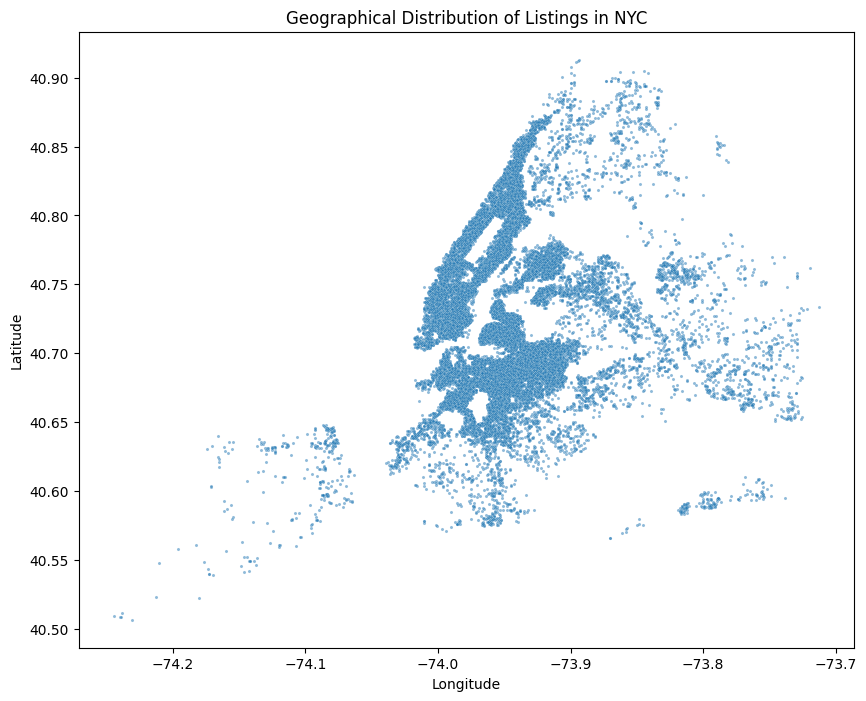

In [14]:
# Geographical distribution of listings
geo_distribution = df.select("latitude", "longitude").toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=geo_distribution, alpha=0.5, s=5)
plt.title('Geographical Distribution of Listings in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

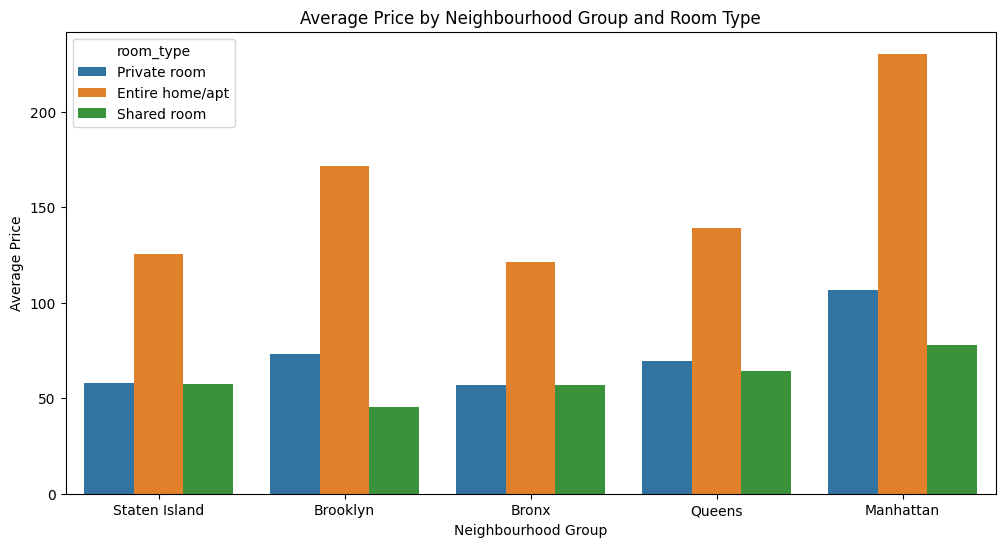

In [15]:
# Average price by neighbourhood group and room type
avg_price_neighbourhood_room = df.groupBy("neighbourhood_group", "room_type").agg(avg("price").alias("average_price")).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='neighbourhood_group', y='average_price', hue='room_type', data=avg_price_neighbourhood_room)
plt.title('Average Price by Neighbourhood Group and Room Type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Price')
plt.show()

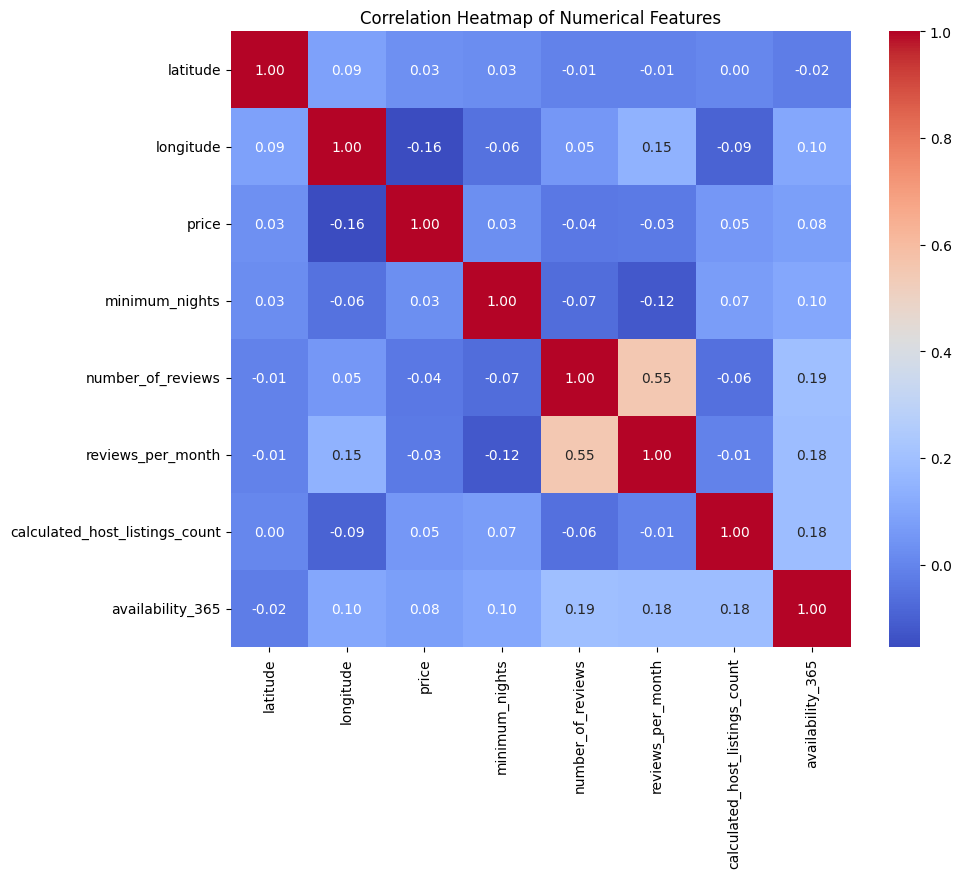

In [16]:
# Correlation heatmap of numerical features
numerical_cols = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
correlation_matrix = df.select(numerical_cols).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Feature Engineering and Outlier Removal

In [17]:
# Removing price outliers
df = df.filter(col("price") <= 500)

# Creating new features
df = df.withColumn("price_per_night", col("price") / col("minimum_nights"))
df = df.withColumn("host_experience",
                  when(col("number_of_reviews") > 100, "Experienced")
                  .when(col("number_of_reviews") > 50, "Intermediate")
                  .otherwise("New"))

# Showing new features
df.select("price", "minimum_nights", "price_per_night", "number_of_reviews", "host_experience").show(5)

+-----+--------------+-----------------+-----------------+---------------+
|price|minimum_nights|  price_per_night|number_of_reviews|host_experience|
+-----+--------------+-----------------+-----------------+---------------+
|149.0|           1.0|            149.0|              9.0|            New|
|225.0|           1.0|            225.0|             45.0|            New|
| 89.0|           1.0|             89.0|            270.0|    Experienced|
| 80.0|          10.0|              8.0|              9.0|            New|
|200.0|           3.0|66.66666666666667|             74.0|   Intermediate|
+-----+--------------+-----------------+-----------------+---------------+
only showing top 5 rows



# Prepare Data for Machine Learning

In [18]:
# Selecting features for modeling
features = ["neighbourhood_group", "room_type", "minimum_nights",
           "number_of_reviews", "reviews_per_month",
           "calculated_host_listings_count", "availability_365",
           "host_experience"]

In [19]:
# Defining stages for the pipeline
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in ["neighbourhood_group", "room_type", "host_experience"]]

assembler = VectorAssembler(
    inputCols=[col+"_index" for col in ["neighbourhood_group", "room_type", "host_experience"]] +
    ["minimum_nights", "number_of_reviews", "reviews_per_month",
     "calculated_host_listings_count", "availability_365"],
    outputCol="features")

In [20]:
# Creating pipeline for feature transformation
pipeline = Pipeline(stages=indexers + [assembler])


In [21]:
# Fitting and transforming the data
transformed_data = pipeline.fit(df).transform(df)

In [22]:
# Splitting data into train and test sets
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)

In [23]:
print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 30495
Test data count: 7561


# Linear Regression

In [24]:
# Initializing Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="price")

# Training the model
lr_model = lr.fit(train_data)

# predictions
lr_predictions = lr_model.transform(test_data)

In [25]:
# Evaluating the model
lr_evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
lr_rmse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "rmse"})
lr_r2 = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}")

Linear Regression RMSE: 69.94452424724126
Linear Regression R2: 0.32387146895640284


In [26]:
# Showing predictions vs actual
lr_predictions.select("price", "prediction").show(10)

+-----+------------------+
|price|        prediction|
+-----+------------------+
| 57.0| 66.76379133483753|
|125.0| 165.7318880714284|
|200.0|167.16917249185724|
|110.0|176.52598048355236|
| 51.0| 100.9501475513137|
|170.0|175.77926086668987|
|150.0|173.18478951900528|
|130.0|160.45330403625215|
|101.0|166.91332932147895|
| 50.0| 77.94165114328739|
+-----+------------------+
only showing top 10 rows



# Random Forest Regression

In [27]:
# Initializing Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="price")

# Training the model
rf_model = rf.fit(train_data)

# predictions
rf_predictions = rf_model.transform(test_data)

In [28]:
# Evaluating the model
rf_rmse = lr_evaluator.evaluate(rf_predictions, {lr_evaluator.metricName: "rmse"})
rf_r2 = lr_evaluator.evaluate(rf_predictions, {lr_evaluator.metricName: "r2"})

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")

Random Forest RMSE: 65.02654665041261
Random Forest R2: 0.4156094253389607


In [29]:
# Feature importance
importances = rf_model.featureImportances
feature_names = ["neighbourhood_group_index", "room_type_index", "host_experience_index",
                "minimum_nights", "number_of_reviews", "reviews_per_month",
                "calculated_host_listings_count", "availability_365"]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances.toArray()
}).sort_values('Importance', ascending=False)

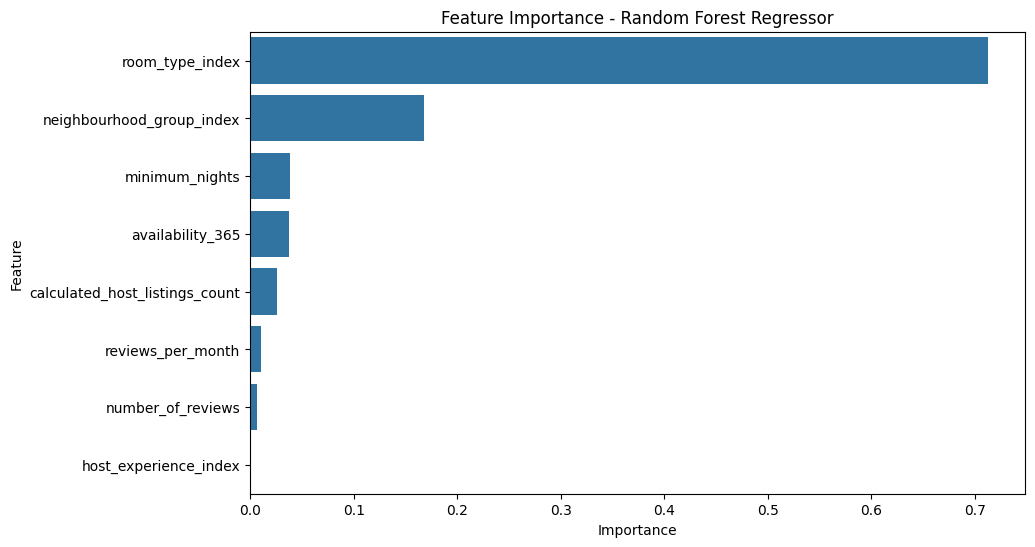

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

In [31]:
# Creating a comparison table
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest Regression'],
    'RMSE': [f"{lr_rmse:.3f}", f"{rf_rmse:.3f}"],
    'R2': [f"{lr_r2:.3f}", f"{rf_r2:.3f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
                      Model    RMSE     R2
0         Linear Regression  69.945  0.324
1  Random Forest Regression  65.027  0.416
